In [34]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms


In [35]:
import pandas as pd

test_df = pd.read_csv("/kaggle/input/mnist-cv-test/mnist_test.csv")

train_df = pd.read_csv("/kaggle/input/mnist-cv-test/mnist_train.csv")



## LOADING DATA

In [36]:
# Function to plot sample images
from tqdm import tqdm

def to_image(df):

    new_df = pd.DataFrame()
    images = []
    labels = []
    for i in tqdm(range(len(df))):
        # Reshape the flattened image to 28x28
        
        image = df.iloc[i, 1:].values.reshape(28, 28) #resize
        image = image/255.0 # Normalize
        
        label = df.iloc[i, 0]
        
        images.append(image)
        labels.append(label)
        
    new_df['images'] = images
    new_df['labels'] = labels

    return new_df
# Plot sample images from the training data
new_train_df = to_image(train_df)
new_test_df = to_image(test_df)

# Plot sample images from the testing data

# new_test_path = "/kaggle/working/test_images.csv"
# new_train_path = "/kaggle/working/train_images.csv"

# new_train_df.to_csv(new_train_path)
# new_test_df.to_csv(new_test_path)

# print(f"images saved to {new_train_path} and {new_test_path}")


100%|██████████| 9999/9999 [00:01<00:00, 9938.55it/s] 


In [37]:
## dataset split
X_train = new_train_df['images'].values
y_train = new_train_df['labels']

test_images = new_test_df['images'].values
test_labels = new_test_df['labels']

y_train = torch.tensor(y_train, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# One-hot encode the labels
num_classes = 10  # Number of classes (0 to 9)
y_train = torch.nn.functional.one_hot(y_train, num_classes=num_classes)
test_labels = torch.nn.functional.one_hot(test_labels, num_classes=num_classes)


X_test = test_images[:len(test_images)//2]
X_val = test_images[len(test_images)//2:]

y_test = test_labels[:len(test_labels)//2]
y_val = test_labels[len(test_labels)//2:]



len(X_train),len(y_train),len(X_test),len(X_val ),len(y_test),len(y_val )

(59999, 59999, 4999, 5000, 4999, 5000)

In [38]:
import numpy as np
for i in tqdm(range(len(X_train))):
    X_train[i] = list(X_train[i])
X_train = list(X_train)
X_train = np.array(X_train, dtype=np.float32)  
X_train = torch.tensor(X_train)


transform = transforms.Normalize(mean=[0.5], std=[0.5])

# Add channel dimension (since it's grayscale)
X_train = X_train.unsqueeze(1)  # Shape becomes [batch_size, 1, height, width]

# Normalize the data
X_train = transform(X_train)

100%|██████████| 59999/59999 [00:00<00:00, 123032.82it/s]


In [39]:
# For X_test
for i in tqdm(range(len(X_test))):
    X_test[i] = list(X_test[i])
X_test = list(X_test)
X_test = np.array(X_test, dtype=np.float32)
X_test = torch.tensor(X_test).unsqueeze(1)  # Add channel dimension
X_test = transform(X_test)  # Normalize

# For X_val
for i in tqdm(range(len(X_val))):
    X_val[i] = list(X_val[i])
X_val = list(X_val)
X_val = np.array(X_val, dtype=np.float32)
X_val = torch.tensor(X_val).unsqueeze(1)  # Add channel dimension
X_val = transform(X_val)  # Normalize

100%|██████████| 5000/5000 [00:00<00:00, 118816.79it/s]


In [40]:
y_train = torch.tensor(y_train)
# y_train = y_train.unsqueeze(1)
y_train.shape

<ipython-input-40-aa5db8dc8cc2>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train)


torch.Size([59999, 10])

In [41]:
y_test = torch.tensor(y_test)
# y_test = y_test.unsqueeze(1)

y_val = torch.tensor(y_val) 
# y_val = y_val.unsqueeze(1)

<ipython-input-41-7d64a92bd736>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test)
<ipython-input-41-7d64a92bd736>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val)


In [42]:
from torch.utils.data import DataLoader, Dataset

class MnistDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [43]:

batch_size = 32

train_dataset = MnistDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MnistDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



val_dataset = MnistDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## TRAINING

In [44]:
import torch
from torch import nn
import torch.nn.functional as F

In [45]:
import torch
import torch.nn as nn

class Block_1(nn.Module):
    def __init__(self):
        super(Block_1, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))  # Reduced kernel size and stride

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        op1 = self.maxpool1(x)
        return op1


class Block_2_1(nn.Module):
    def __init__(self):
        super(Block_2_1, self).__init__()
        self.relu = nn.ReLU()
        self.dropout_percentage = 0.5

        self.conv2_1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batchnorm2_1_1 = nn.BatchNorm2d(64)
        self.conv2_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batchnorm2_1_2 = nn.BatchNorm2d(64)
        self.dropout2_1 = nn.Dropout(p=self.dropout_percentage)

    def forward(self, op1):
        x = self.conv2_1_1(op1)
        x = self.batchnorm2_1_1(x)
        x = self.relu(x)
        x = self.conv2_1_2(x)
        x = self.batchnorm2_1_2(x)
        x = self.dropout2_1(x)
        op2_1 = self.relu(x + op1)
        return op2_1


class Block_2_2(nn.Module):
    def __init__(self):
        super(Block_2_2, self).__init__()
        self.relu = nn.ReLU()
        self.dropout_percentage = 0.5

        self.conv2_2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batchnorm2_2_1 = nn.BatchNorm2d(64)
        self.conv2_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batchnorm2_2_2 = nn.BatchNorm2d(64)
        self.dropout2_2 = nn.Dropout(p=self.dropout_percentage)

    def forward(self, op2_1):
        x = self.conv2_2_1(op2_1)
        x = self.batchnorm2_2_1(x)
        x = self.relu(x)
        x = self.conv2_2_2(x)
        x = self.batchnorm2_2_2(x)
        x = self.dropout2_2(x)
        op2 = self.relu(x + op2_1)
        return op2


class Block_3(nn.Module):
    def __init__(self):
        super(Block_3, self).__init__()
        self.relu = nn.ReLU()
        self.dropout_percentage = 0.5

        self.conv3_1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.batchnorm3_1_1 = nn.BatchNorm2d(128)
        self.conv3_1_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batchnorm3_1_2 = nn.BatchNorm2d(128)

        # Skip connection
        self.concat_adjust_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1), stride=(2, 2), padding=(0, 0))
        self.dropout3_1 = nn.Dropout(p=self.dropout_percentage)

        self.conv3_2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batchnorm3_2_1 = nn.BatchNorm2d(128)
        self.conv3_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batchnorm3_2_2 = nn.BatchNorm2d(128)
        self.dropout3_2 = nn.Dropout(p=self.dropout_percentage)

    def forward(self, op2):
        x = self.conv3_1_1(op2)
        x = self.batchnorm3_1_1(x)
        x = self.relu(x)
        x = self.conv3_1_2(x)
        x = self.batchnorm3_1_2(x)
        x = self.dropout3_1(x)

        op2 = self.concat_adjust_3(op2)  # Skip connection
        op3_1 = self.relu(x + op2)

        x = self.conv3_2_1(op3_1)
        x = self.batchnorm3_2_1(x)
        x = self.relu(x)
        x = self.conv3_2_2(x)
        x = self.batchnorm3_2_2(x)
        x = self.dropout3_2(x)
        op3 = self.relu(x + op3_1)

        return op3


class Resnet18(nn.Module):
    def __init__(self, n_classes):
        super(Resnet18, self).__init__()

        self.block1 = Block_1()
        self.block2_1 = Block_2_1()
        self.block2_2 = Block_2_2()
        self.block3 = Block_3()

        # Final block
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Dynamically adjust pooling size
        self.fc = nn.Linear(in_features=128, out_features=1000)
        self.out = nn.Linear(in_features=1000, out_features=n_classes)

    def forward(self, x):
        op1 = self.block1(x)
        op2_1 = self.block2_1(op1)
        op2 = self.block2_2(op2_1)
        op3 = self.block3(op2)

        x = self.avgpool(op3)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        x = self.out(x)

        return x

In [46]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.optim as optim



class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


output_size = 10
learning_rate = 0.001
batch_size = 32
num_epochs = 10 #10
n_classes = 10
# Instantiate the model, loss function, and optimizer
model = Resnet18(n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
early_stopping = EarlyStopping(patience=5, min_delta=0.01)




In [47]:



def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader , desc = "Processing accuracy..." ):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

            # If labels are one-hot encoded, convert them to class indices
            if labels.dim() > 1 and labels.size(1) > 1:  # Check if labels are one-hot encoded
                labels = torch.argmax(labels, dim=1)  # Convert to class indices

            # Compare predicted and true class indices
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # print(correct / total)

    
    return 100 * correct / total




In [48]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for i, (inputs, labels) in tqdm(enumerate(train_loader) , desc = "training over Batches"):
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.squeeze(1)

        # labels = labels.long()
        labels = labels.float()

        try:
        # print(outputs.shape,labels.shape)
            loss = criterion(outputs, labels)
        except Exception as e:
            print(e)
            continue
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')


    
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader , desc = "calculating test loss over an epoch.."):
            outputs = model(inputs)
            outputs = outputs.squeeze(1)


            labels = labels.float()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    # Calculate Loss

    
    
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)


    
    # Calculate accuracy
    train_acc = calculate_accuracy(train_loader, model)
    test_acc = calculate_accuracy(test_loader, model)


    

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f} '
          f'Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')


    scheduler.step(test_loss)

    early_stopping(test_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break
print('Training complete.')

training over Batches: 101it [00:11,  9.93it/s]

Epoch [1/10], Step [100/1875], Loss: 0.4911


training over Batches: 202it [00:21,  9.97it/s]

Epoch [1/10], Step [200/1875], Loss: 0.4365


training over Batches: 301it [00:31,  9.97it/s]

Epoch [1/10], Step [300/1875], Loss: 0.3736


training over Batches: 401it [00:42,  9.80it/s]

Epoch [1/10], Step [400/1875], Loss: 0.2486


training over Batches: 501it [00:52, 10.03it/s]

Epoch [1/10], Step [500/1875], Loss: 0.3119


training over Batches: 601it [01:02, 10.08it/s]

Epoch [1/10], Step [600/1875], Loss: 0.3482


training over Batches: 701it [01:13,  9.98it/s]

Epoch [1/10], Step [700/1875], Loss: 0.0707


training over Batches: 801it [01:23,  9.93it/s]

Epoch [1/10], Step [800/1875], Loss: 0.0424


training over Batches: 901it [01:33, 10.22it/s]

Epoch [1/10], Step [900/1875], Loss: 0.1066


training over Batches: 1001it [01:43, 10.50it/s]

Epoch [1/10], Step [1000/1875], Loss: 0.0205


training over Batches: 1102it [01:53, 10.20it/s]

Epoch [1/10], Step [1100/1875], Loss: 0.0303


training over Batches: 1202it [02:03, 10.21it/s]

Epoch [1/10], Step [1200/1875], Loss: 0.0627


training over Batches: 1301it [02:13, 10.35it/s]

Epoch [1/10], Step [1300/1875], Loss: 0.0285


training over Batches: 1400it [02:23, 10.09it/s]

Epoch [1/10], Step [1400/1875], Loss: 0.0581


training over Batches: 1500it [02:33, 10.31it/s]

Epoch [1/10], Step [1500/1875], Loss: 0.0716


training over Batches: 1601it [02:44,  9.12it/s]

Epoch [1/10], Step [1600/1875], Loss: 0.0073


training over Batches: 1700it [02:54, 10.12it/s]

Epoch [1/10], Step [1700/1875], Loss: 0.0635


training over Batches: 1801it [03:04, 10.18it/s]

Epoch [1/10], Step [1800/1875], Loss: 0.0571


training over Batches: 1875it [03:11,  9.79it/s]
Processing accuracy...: 100%|██████████| 157/157 [00:04<00:00, 33.06it/s]


Epoch [1/10], Train Loss: 0.1809, Val Loss: 0.0766 Train Accuracy: 97.87%, Test Accuracy: 97.54%


training over Batches: 101it [00:10,  9.45it/s]

Epoch [2/10], Step [100/1875], Loss: 0.0558


training over Batches: 201it [00:20,  9.62it/s]

Epoch [2/10], Step [200/1875], Loss: 0.0394


training over Batches: 301it [00:30,  9.22it/s]

Epoch [2/10], Step [300/1875], Loss: 0.0289


training over Batches: 401it [00:41, 10.02it/s]

Epoch [2/10], Step [400/1875], Loss: 0.0026


training over Batches: 502it [00:51, 10.02it/s]

Epoch [2/10], Step [500/1875], Loss: 0.0096


training over Batches: 602it [01:01, 10.07it/s]

Epoch [2/10], Step [600/1875], Loss: 0.0664


training over Batches: 701it [01:12,  9.92it/s]

Epoch [2/10], Step [700/1875], Loss: 0.0310


training over Batches: 801it [01:22, 10.23it/s]

Epoch [2/10], Step [800/1875], Loss: 0.0263


training over Batches: 902it [01:32, 10.18it/s]

Epoch [2/10], Step [900/1875], Loss: 0.0269


training over Batches: 1001it [01:43, 10.07it/s]

Epoch [2/10], Step [1000/1875], Loss: 0.2359


training over Batches: 1102it [01:53,  9.93it/s]

Epoch [2/10], Step [1100/1875], Loss: 0.0283


training over Batches: 1202it [02:03, 10.09it/s]

Epoch [2/10], Step [1200/1875], Loss: 0.0059


training over Batches: 1302it [02:14, 10.17it/s]

Epoch [2/10], Step [1300/1875], Loss: 0.0173


training over Batches: 1402it [02:24,  9.99it/s]

Epoch [2/10], Step [1400/1875], Loss: 0.3048


training over Batches: 1501it [02:33, 10.07it/s]

Epoch [2/10], Step [1500/1875], Loss: 0.0561


training over Batches: 1601it [02:44, 10.40it/s]

Epoch [2/10], Step [1600/1875], Loss: 0.1797


training over Batches: 1701it [02:54, 10.21it/s]

Epoch [2/10], Step [1700/1875], Loss: 0.0147


training over Batches: 1801it [03:04, 10.00it/s]

Epoch [2/10], Step [1800/1875], Loss: 0.0030


training over Batches: 1875it [03:11,  9.77it/s]
Processing accuracy...: 100%|██████████| 157/157 [00:05<00:00, 28.43it/s]


Epoch [2/10], Train Loss: 0.0760, Val Loss: 0.0541 Train Accuracy: 98.57%, Test Accuracy: 98.30%


training over Batches: 102it [00:10,  9.93it/s]

Epoch [3/10], Step [100/1875], Loss: 0.0139


training over Batches: 200it [00:20, 10.11it/s]

Epoch [3/10], Step [200/1875], Loss: 0.0088


training over Batches: 301it [00:31,  8.82it/s]

Epoch [3/10], Step [300/1875], Loss: 0.0012


training over Batches: 401it [00:41,  9.43it/s]

Epoch [3/10], Step [400/1875], Loss: 0.0080


training over Batches: 501it [00:51,  9.66it/s]

Epoch [3/10], Step [500/1875], Loss: 0.0080


training over Batches: 601it [01:02,  7.11it/s]

Epoch [3/10], Step [600/1875], Loss: 0.0443


training over Batches: 701it [01:12,  9.82it/s]

Epoch [3/10], Step [700/1875], Loss: 0.0042


training over Batches: 801it [01:22,  9.68it/s]

Epoch [3/10], Step [800/1875], Loss: 0.0068


training over Batches: 901it [01:32,  9.78it/s]

Epoch [3/10], Step [900/1875], Loss: 0.0040


training over Batches: 1002it [01:43,  9.97it/s]

Epoch [3/10], Step [1000/1875], Loss: 0.0088


training over Batches: 1101it [01:53, 10.05it/s]

Epoch [3/10], Step [1100/1875], Loss: 0.0026


training over Batches: 1202it [02:04, 10.25it/s]

Epoch [3/10], Step [1200/1875], Loss: 0.1661


training over Batches: 1301it [02:14,  9.98it/s]

Epoch [3/10], Step [1300/1875], Loss: 0.0451


training over Batches: 1400it [02:24, 10.01it/s]

Epoch [3/10], Step [1400/1875], Loss: 0.0718


training over Batches: 1502it [02:34,  9.96it/s]

Epoch [3/10], Step [1500/1875], Loss: 0.0453


training over Batches: 1601it [02:45, 10.06it/s]

Epoch [3/10], Step [1600/1875], Loss: 0.0041


training over Batches: 1701it [02:55,  9.93it/s]

Epoch [3/10], Step [1700/1875], Loss: 0.0014


training over Batches: 1801it [03:05,  9.85it/s]

Epoch [3/10], Step [1800/1875], Loss: 0.0017


training over Batches: 1875it [03:13,  9.67it/s]
Processing accuracy...: 100%|██████████| 157/157 [00:05<00:00, 29.15it/s]


Epoch [3/10], Train Loss: 0.0587, Val Loss: 0.0442 Train Accuracy: 99.11%, Test Accuracy: 98.52%


training over Batches: 101it [00:10,  9.84it/s]

Epoch [4/10], Step [100/1875], Loss: 0.0098


training over Batches: 202it [00:20, 10.23it/s]

Epoch [4/10], Step [200/1875], Loss: 0.0357


training over Batches: 301it [00:30,  8.98it/s]

Epoch [4/10], Step [300/1875], Loss: 0.0065


training over Batches: 402it [00:40,  9.55it/s]

Epoch [4/10], Step [400/1875], Loss: 0.0261


training over Batches: 501it [00:50,  9.25it/s]

Epoch [4/10], Step [500/1875], Loss: 0.0003


training over Batches: 601it [01:01,  6.94it/s]

Epoch [4/10], Step [600/1875], Loss: 0.0009


training over Batches: 701it [01:11,  9.98it/s]

Epoch [4/10], Step [700/1875], Loss: 0.1888


training over Batches: 801it [01:21,  9.71it/s]

Epoch [4/10], Step [800/1875], Loss: 0.0691


training over Batches: 900it [01:31, 10.01it/s]

Epoch [4/10], Step [900/1875], Loss: 0.1289


training over Batches: 1000it [01:42, 10.04it/s]

Epoch [4/10], Step [1000/1875], Loss: 0.0004


training over Batches: 1102it [01:52, 10.43it/s]

Epoch [4/10], Step [1100/1875], Loss: 0.0065


training over Batches: 1202it [02:02,  9.98it/s]

Epoch [4/10], Step [1200/1875], Loss: 0.0065


training over Batches: 1301it [02:13, 10.10it/s]

Epoch [4/10], Step [1300/1875], Loss: 0.0404


training over Batches: 1402it [02:23, 10.14it/s]

Epoch [4/10], Step [1400/1875], Loss: 0.2038


training over Batches: 1502it [02:33, 10.22it/s]

Epoch [4/10], Step [1500/1875], Loss: 0.0027


training over Batches: 1601it [02:44,  9.72it/s]

Epoch [4/10], Step [1600/1875], Loss: 0.0027


training over Batches: 1702it [02:54, 10.16it/s]

Epoch [4/10], Step [1700/1875], Loss: 0.1077


training over Batches: 1801it [03:04,  9.85it/s]

Epoch [4/10], Step [1800/1875], Loss: 0.0348


training over Batches: 1875it [03:12,  9.76it/s]
Processing accuracy...: 100%|██████████| 157/157 [00:04<00:00, 32.12it/s]


Epoch [4/10], Train Loss: 0.0501, Val Loss: 0.0420 Train Accuracy: 99.02%, Test Accuracy: 98.64%


training over Batches: 101it [00:10, 10.24it/s]

Epoch [5/10], Step [100/1875], Loss: 0.0067


training over Batches: 201it [00:20, 10.06it/s]

Epoch [5/10], Step [200/1875], Loss: 0.0499


training over Batches: 301it [00:31,  9.26it/s]

Epoch [5/10], Step [300/1875], Loss: 0.0048


training over Batches: 401it [00:41,  9.69it/s]

Epoch [5/10], Step [400/1875], Loss: 0.0262


training over Batches: 501it [00:51,  9.69it/s]

Epoch [5/10], Step [500/1875], Loss: 0.0123


training over Batches: 601it [01:01,  9.86it/s]

Epoch [5/10], Step [600/1875], Loss: 0.0624


training over Batches: 701it [01:11,  9.70it/s]

Epoch [5/10], Step [700/1875], Loss: 0.0111


training over Batches: 801it [01:21, 10.00it/s]

Epoch [5/10], Step [800/1875], Loss: 0.0291


training over Batches: 901it [01:32,  7.08it/s]

Epoch [5/10], Step [900/1875], Loss: 0.0071


training over Batches: 1001it [01:42,  9.80it/s]

Epoch [5/10], Step [1000/1875], Loss: 0.0899


training over Batches: 1101it [01:52, 10.16it/s]

Epoch [5/10], Step [1100/1875], Loss: 0.0361


training over Batches: 1201it [02:02,  9.82it/s]

Epoch [5/10], Step [1200/1875], Loss: 0.0040


training over Batches: 1301it [02:12,  9.77it/s]

Epoch [5/10], Step [1300/1875], Loss: 0.0055


training over Batches: 1401it [02:22,  9.66it/s]

Epoch [5/10], Step [1400/1875], Loss: 0.0068


training over Batches: 1502it [02:33, 10.13it/s]

Epoch [5/10], Step [1500/1875], Loss: 0.0029


training over Batches: 1600it [02:43, 10.16it/s]

Epoch [5/10], Step [1600/1875], Loss: 0.0117


training over Batches: 1702it [02:53, 10.13it/s]

Epoch [5/10], Step [1700/1875], Loss: 0.0853


training over Batches: 1802it [03:03, 10.12it/s]

Epoch [5/10], Step [1800/1875], Loss: 0.0015


training over Batches: 1875it [03:11,  9.79it/s]
Processing accuracy...: 100%|██████████| 157/157 [00:04<00:00, 33.64it/s]


Epoch [5/10], Train Loss: 0.0432, Val Loss: 0.0269 Train Accuracy: 99.37%, Test Accuracy: 99.10%


training over Batches: 100it [00:10, 10.03it/s]

Epoch [6/10], Step [100/1875], Loss: 0.0136


training over Batches: 202it [00:20, 10.28it/s]

Epoch [6/10], Step [200/1875], Loss: 0.0003


training over Batches: 302it [00:31, 10.28it/s]

Epoch [6/10], Step [300/1875], Loss: 0.0011


training over Batches: 401it [00:40,  9.67it/s]

Epoch [6/10], Step [400/1875], Loss: 0.0080


training over Batches: 501it [00:51,  9.77it/s]

Epoch [6/10], Step [500/1875], Loss: 0.0020


training over Batches: 601it [01:01, 10.10it/s]

Epoch [6/10], Step [600/1875], Loss: 0.0076


training over Batches: 701it [01:11,  9.76it/s]

Epoch [6/10], Step [700/1875], Loss: 0.0372


training over Batches: 801it [01:22, 10.00it/s]

Epoch [6/10], Step [800/1875], Loss: 0.0010


training over Batches: 900it [01:32,  9.41it/s]

Epoch [6/10], Step [900/1875], Loss: 0.0077


training over Batches: 1002it [01:43,  9.55it/s]

Epoch [6/10], Step [1000/1875], Loss: 0.0018


training over Batches: 1101it [01:52,  9.50it/s]

Epoch [6/10], Step [1100/1875], Loss: 0.0017


training over Batches: 1201it [02:03,  8.71it/s]

Epoch [6/10], Step [1200/1875], Loss: 0.0169


training over Batches: 1301it [02:13, 10.09it/s]

Epoch [6/10], Step [1300/1875], Loss: 0.0038


training over Batches: 1401it [02:23, 10.13it/s]

Epoch [6/10], Step [1400/1875], Loss: 0.0014


training over Batches: 1501it [02:34,  7.98it/s]

Epoch [6/10], Step [1500/1875], Loss: 0.0098


training over Batches: 1601it [02:44,  9.94it/s]

Epoch [6/10], Step [1600/1875], Loss: 0.0062


training over Batches: 1702it [02:54, 10.16it/s]

Epoch [6/10], Step [1700/1875], Loss: 0.0840


training over Batches: 1802it [03:04, 10.14it/s]

Epoch [6/10], Step [1800/1875], Loss: 0.0152


training over Batches: 1875it [03:12,  9.73it/s]
Processing accuracy...: 100%|██████████| 157/157 [00:04<00:00, 33.87it/s]


Epoch [6/10], Train Loss: 0.0393, Val Loss: 0.0346 Train Accuracy: 99.46%, Test Accuracy: 99.00%


training over Batches: 101it [00:10,  9.94it/s]

Epoch [7/10], Step [100/1875], Loss: 0.0012


training over Batches: 202it [00:20, 10.11it/s]

Epoch [7/10], Step [200/1875], Loss: 0.0872


training over Batches: 301it [00:30,  9.66it/s]

Epoch [7/10], Step [300/1875], Loss: 0.0048


training over Batches: 401it [00:40, 10.06it/s]

Epoch [7/10], Step [400/1875], Loss: 0.0988


training over Batches: 501it [00:50,  9.75it/s]

Epoch [7/10], Step [500/1875], Loss: 0.0028


training over Batches: 601it [01:01, 10.08it/s]

Epoch [7/10], Step [600/1875], Loss: 0.0851


training over Batches: 702it [01:11, 10.06it/s]

Epoch [7/10], Step [700/1875], Loss: 0.0016


training over Batches: 800it [01:21, 10.21it/s]

Epoch [7/10], Step [800/1875], Loss: 0.0035


training over Batches: 901it [01:31, 10.22it/s]

Epoch [7/10], Step [900/1875], Loss: 0.0732


training over Batches: 1001it [01:41, 10.23it/s]

Epoch [7/10], Step [1000/1875], Loss: 0.0003


training over Batches: 1101it [01:51,  9.66it/s]

Epoch [7/10], Step [1100/1875], Loss: 0.0016


training over Batches: 1201it [02:02, 10.35it/s]

Epoch [7/10], Step [1200/1875], Loss: 0.0047


training over Batches: 1301it [02:12, 10.13it/s]

Epoch [7/10], Step [1300/1875], Loss: 0.0333


training over Batches: 1402it [02:22,  9.83it/s]

Epoch [7/10], Step [1400/1875], Loss: 0.1410


training over Batches: 1501it [02:32,  9.35it/s]

Epoch [7/10], Step [1500/1875], Loss: 0.1687


training over Batches: 1601it [02:42,  9.80it/s]

Epoch [7/10], Step [1600/1875], Loss: 0.0003


training over Batches: 1701it [02:52,  8.93it/s]

Epoch [7/10], Step [1700/1875], Loss: 0.0015


training over Batches: 1801it [03:02,  7.11it/s]

Epoch [7/10], Step [1800/1875], Loss: 0.0454


training over Batches: 1875it [03:10,  9.86it/s]
Processing accuracy...: 100%|██████████| 157/157 [00:04<00:00, 33.57it/s]


Epoch [7/10], Train Loss: 0.0346, Val Loss: 0.0493 Train Accuracy: 99.20%, Test Accuracy: 98.44%


training over Batches: 101it [00:10, 10.09it/s]

Epoch [8/10], Step [100/1875], Loss: 0.0587


training over Batches: 201it [00:19, 10.22it/s]

Epoch [8/10], Step [200/1875], Loss: 0.0008


training over Batches: 301it [00:30, 10.16it/s]

Epoch [8/10], Step [300/1875], Loss: 0.0002


training over Batches: 401it [00:40,  9.76it/s]

Epoch [8/10], Step [400/1875], Loss: 0.0116


training over Batches: 501it [00:50, 10.13it/s]

Epoch [8/10], Step [500/1875], Loss: 0.0002


training over Batches: 602it [01:01, 10.31it/s]

Epoch [8/10], Step [600/1875], Loss: 0.0335


training over Batches: 701it [01:10, 10.22it/s]

Epoch [8/10], Step [700/1875], Loss: 0.0007


training over Batches: 802it [01:20, 10.18it/s]

Epoch [8/10], Step [800/1875], Loss: 0.2174


training over Batches: 901it [01:31, 10.06it/s]

Epoch [8/10], Step [900/1875], Loss: 0.0014


training over Batches: 1001it [01:41, 10.35it/s]

Epoch [8/10], Step [1000/1875], Loss: 0.0002


training over Batches: 1102it [01:51, 10.23it/s]

Epoch [8/10], Step [1100/1875], Loss: 0.1946


training over Batches: 1201it [02:01,  9.85it/s]

Epoch [8/10], Step [1200/1875], Loss: 0.0313


training over Batches: 1301it [02:11, 10.17it/s]

Epoch [8/10], Step [1300/1875], Loss: 0.0393


training over Batches: 1401it [02:21, 10.08it/s]

Epoch [8/10], Step [1400/1875], Loss: 0.0003


training over Batches: 1501it [02:31,  7.83it/s]

Epoch [8/10], Step [1500/1875], Loss: 0.0021


training over Batches: 1601it [02:42, 10.18it/s]

Epoch [8/10], Step [1600/1875], Loss: 0.0010


training over Batches: 1701it [02:52, 10.10it/s]

Epoch [8/10], Step [1700/1875], Loss: 0.0503


training over Batches: 1801it [03:02,  9.76it/s]

Epoch [8/10], Step [1800/1875], Loss: 0.0236


training over Batches: 1875it [03:10,  9.86it/s]
Processing accuracy...: 100%|██████████| 157/157 [00:04<00:00, 34.44it/s]


Epoch [8/10], Train Loss: 0.0333, Val Loss: 0.0295 Train Accuracy: 99.62%, Test Accuracy: 99.08%


training over Batches: 101it [00:09, 10.14it/s]

Epoch [9/10], Step [100/1875], Loss: 0.0007


training over Batches: 200it [00:19, 10.18it/s]

Epoch [9/10], Step [200/1875], Loss: 0.0047


training over Batches: 302it [00:30,  9.87it/s]

Epoch [9/10], Step [300/1875], Loss: 0.0022


training over Batches: 401it [00:40,  9.81it/s]

Epoch [9/10], Step [400/1875], Loss: 0.0781


training over Batches: 501it [00:50,  9.87it/s]

Epoch [9/10], Step [500/1875], Loss: 0.0003


training over Batches: 601it [01:01, 10.07it/s]

Epoch [9/10], Step [600/1875], Loss: 0.0040


training over Batches: 701it [01:11,  9.98it/s]

Epoch [9/10], Step [700/1875], Loss: 0.0198


training over Batches: 802it [01:21, 10.03it/s]

Epoch [9/10], Step [800/1875], Loss: 0.0010


training over Batches: 901it [01:32,  9.68it/s]

Epoch [9/10], Step [900/1875], Loss: 0.0026


training over Batches: 1001it [01:42, 10.27it/s]

Epoch [9/10], Step [1000/1875], Loss: 0.0017


training over Batches: 1101it [01:52, 10.12it/s]

Epoch [9/10], Step [1100/1875], Loss: 0.0008


training over Batches: 1201it [02:03,  8.28it/s]

Epoch [9/10], Step [1200/1875], Loss: 0.0001


training over Batches: 1301it [02:13,  9.84it/s]

Epoch [9/10], Step [1300/1875], Loss: 0.0005


training over Batches: 1401it [02:23,  9.64it/s]

Epoch [9/10], Step [1400/1875], Loss: 0.0010


training over Batches: 1501it [02:33,  8.19it/s]

Epoch [9/10], Step [1500/1875], Loss: 0.0567


training over Batches: 1601it [02:43, 10.04it/s]

Epoch [9/10], Step [1600/1875], Loss: 0.0013


training over Batches: 1701it [02:54,  9.68it/s]

Epoch [9/10], Step [1700/1875], Loss: 0.0049


training over Batches: 1802it [03:04, 10.11it/s]

Epoch [9/10], Step [1800/1875], Loss: 0.0014


training over Batches: 1875it [03:12,  9.76it/s]
Processing accuracy...: 100%|██████████| 157/157 [00:04<00:00, 34.14it/s]


Epoch [9/10], Train Loss: 0.0273, Val Loss: 0.0240 Train Accuracy: 99.62%, Test Accuracy: 99.14%


training over Batches: 100it [00:09, 10.29it/s]

Epoch [10/10], Step [100/1875], Loss: 0.0006


training over Batches: 202it [00:19, 10.24it/s]

Epoch [10/10], Step [200/1875], Loss: 0.0081


training over Batches: 300it [00:30, 10.14it/s]

Epoch [10/10], Step [300/1875], Loss: 0.0022


training over Batches: 401it [00:40, 10.17it/s]

Epoch [10/10], Step [400/1875], Loss: 0.0122


training over Batches: 501it [00:50, 10.21it/s]

Epoch [10/10], Step [500/1875], Loss: 0.0024


training over Batches: 602it [01:00, 10.33it/s]

Epoch [10/10], Step [600/1875], Loss: 0.0002


training over Batches: 701it [01:11, 10.01it/s]

Epoch [10/10], Step [700/1875], Loss: 0.1831


training over Batches: 802it [01:21,  9.99it/s]

Epoch [10/10], Step [800/1875], Loss: 0.0017


training over Batches: 901it [01:31,  9.39it/s]

Epoch [10/10], Step [900/1875], Loss: 0.0304


training over Batches: 1001it [01:41,  9.85it/s]

Epoch [10/10], Step [1000/1875], Loss: 0.1414


training over Batches: 1101it [01:51, 10.05it/s]

Epoch [10/10], Step [1100/1875], Loss: 0.1100


training over Batches: 1201it [02:02,  7.40it/s]

Epoch [10/10], Step [1200/1875], Loss: 0.0003


training over Batches: 1302it [02:12, 10.15it/s]

Epoch [10/10], Step [1300/1875], Loss: 0.1828


training over Batches: 1401it [02:22,  9.76it/s]

Epoch [10/10], Step [1400/1875], Loss: 0.0093


training over Batches: 1501it [02:32,  7.72it/s]

Epoch [10/10], Step [1500/1875], Loss: 0.0613


training over Batches: 1601it [02:43,  9.68it/s]

Epoch [10/10], Step [1600/1875], Loss: 0.0072


training over Batches: 1701it [02:53,  9.80it/s]

Epoch [10/10], Step [1700/1875], Loss: 0.0027


training over Batches: 1801it [03:03, 10.05it/s]

Epoch [10/10], Step [1800/1875], Loss: 0.0103


training over Batches: 1875it [03:11,  9.80it/s]
Processing accuracy...: 100%|██████████| 157/157 [00:04<00:00, 33.94it/s]

Epoch [10/10], Train Loss: 0.0274, Val Loss: 0.0423 Train Accuracy: 99.27%, Test Accuracy: 98.64%
Early stopping triggered!
Training complete.


## EVALUATION 

In [49]:
import torch
from sklearn.metrics import precision_score, recall_score
import numpy as np

def calculate_metrics(loader, model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices
            
            if labels.dim() > 1 and labels.size(1) > 1:  # Check if labels are one-hot encoded
                labels = torch.argmax(labels, dim=1)

            
            all_preds.extend(predicted.cpu().numpy())
            
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate accuracy
    accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)

    # Calculate precision and recall
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    return accuracy, precision, recall

accuracy, precision, recall = calculate_metrics(val_loader, model)

# Print results
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 99.26%
Precision: 0.9925
Recall: 0.9925


## Testing and GRAD_CAM creation


In [50]:
# Save the model as a .pth file
pth_file_path = "/kaggle/working/resnet18_v1.pth"
torch.save(model.state_dict(), pth_file_path)

print(f"Model saved to {pth_file_path}")


Model saved to /kaggle/working/resnet18_v1.pth


In [24]:
# Instantiate the model (make sure to define Resnet18 class before loading)
model = Resnet18(n_classes=10)

# Load the saved weights
model.load_state_dict(torch.load(pth_file_path))
model.eval()

# Example inference
with torch.no_grad():
    sample_input = train_dataset[1][0].unsqueeze(0)  # Add batch dimension
    output = model(sample_input)
    predicted_class = output.argmax(dim=1).item()

print(f"Predicted class: {predicted_class}")


Predicted class: 4


<ipython-input-24-1713a2546997>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth_file_path))


In [31]:
from PIL import Image



transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x + 1) / 2), # Scale [-1, 1] to [0, 1]
    transforms.Lambda(lambda x: x * 255)  
    ])



# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("L")
    image = image.resize((28, 28)) 

    image = np.array(image)
        
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 28, 28)

    print("Processed image shape:", image.shape)
    # print(image)
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
    print("processed image :",image.shape)
    return image

# Predict
def predict(image_path,model):
    input_data = preprocess_image(image_path)
    # print(input_data)
    with torch.no_grad():
        outputs = model(input_data)
        print(outputs)
        _, predicted_class = torch.max(outputs.data, 1)
    return predicted_class


image_path = "/kaggle/input/7example/digit.png"

predicted_class = predict(image_path, model)
print(f"Predicted class: {predicted_class}")


Processed image shape: torch.Size([1, 28, 28])
processed image : torch.Size([1, 1, 28, 28])
tensor([[   9.2400, -759.2546,  848.8665, -171.4278, -501.6982, -198.3290,
          267.7304, -245.0454,  442.6352,   21.3845]])
Predicted class: tensor([2])


<ipython-input-31-bc59ee8d6d36>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)


In [84]:

from torchvision import transforms
from PIL import Image
import numpy as np


image_path = "/kaggle/input/example-image/example1.jpg"  # Path to your 28x28 image
image = Image.open(image_path).convert("L")  # Convert to grayscale

# Define preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 28x28 (if needed)
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize (if required)
])

# Preprocess the image
input_tensor = preprocess(image)  # Shape: [1, 28, 28]
input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension: [1, 1, 28, 28]

# Perform inference
with torch.no_grad():
    output = model(input_tensor)

# Interpret the output
predicted_class = torch.argmax(output, dim=1).item()
print(f"Predicted class: {predicted_class}")


Predicted class: 3


In [21]:
print(model)
conv_layers =[model.block1.conv1,
              model.block2_1.conv2_1_1,model.block2_1.conv2_1_2,
              model.block2_2.conv2_2_1,model.block2_2.conv2_2_2,
              model.block3.conv3_1_1,model.block3.conv3_1_2,
              model.block3.conv3_2_1,model.block3.conv3_2_2  ] 

Resnet18(
  (block1): Block_1(
    (relu): ReLU()
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  )
  (block2_1): Block_2_1(
    (relu): ReLU()
    (conv2_1_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2_1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2_1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2_1): Dropout(p=0.5, inplace=False)
  )
  (block2_2): Block_2_2(
    (relu): ReLU()
    (conv2_2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2_2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

<ipython-input-52-8eef241cc640>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/resnet18_v1.pth"))


Predicted class: tensor([7], device='cuda:0')


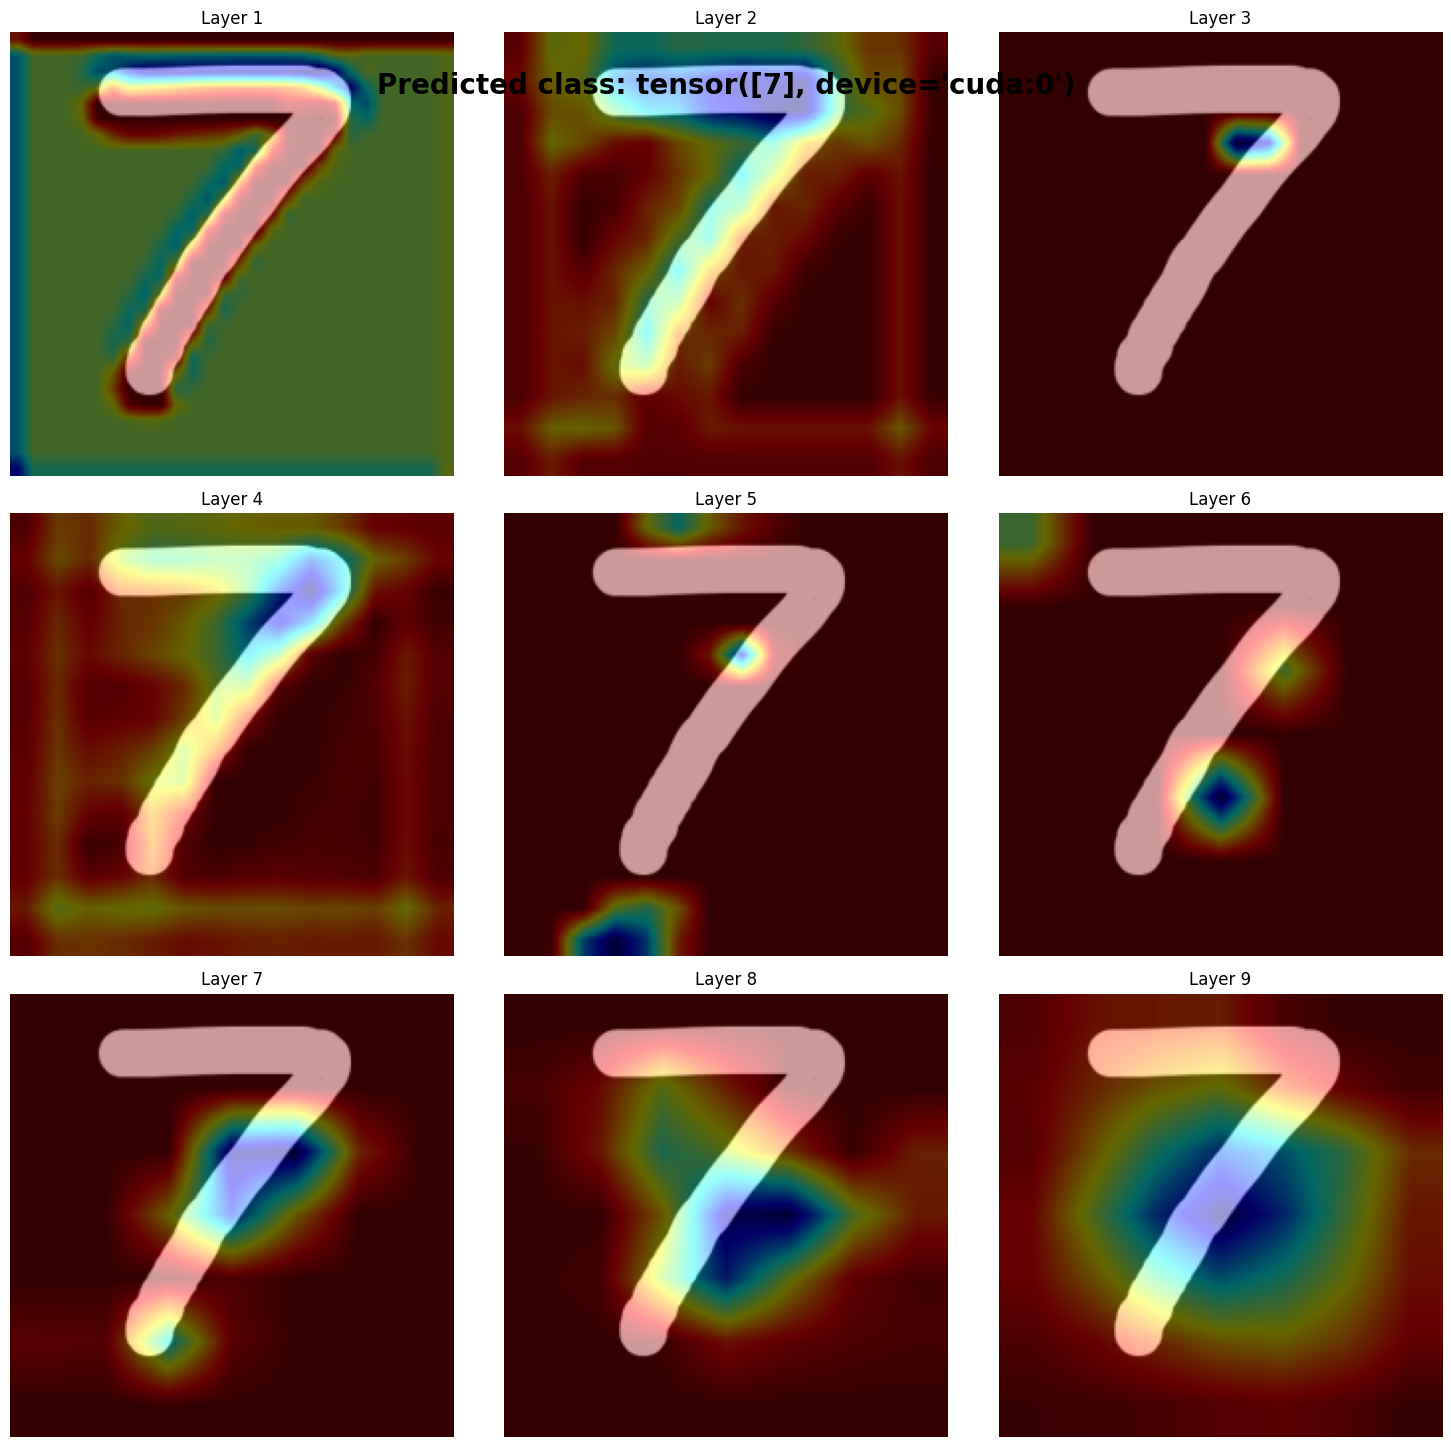

In [52]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Load Model and Image 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Resnet18(n_classes=10).to(device)



model.load_state_dict(torch.load("/kaggle/working/resnet18_v1.pth"))
model.eval()

# Load and preprocess image
img = Image.open("/kaggle/input/7example/digit.png").convert('L')
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
input_tensor = transform(img).unsqueeze(0).to(device)

# List of target layers 
conv_layers = [
    model.block1.conv1,
    model.block2_1.conv2_1_1, model.block2_1.conv2_1_2,
    model.block2_2.conv2_2_1, model.block2_2.conv2_2_2,
    model.block3.conv3_1_1, model.block3.conv3_1_2,
    model.block3.conv3_2_1, model.block3.conv3_2_2
]

# Store gradients and activations 
gradients = {}
activations = {}

def save_grad(name):
    def hook(module, input, output):
        output.register_hook(lambda grad: gradients.update({name: grad}))
        activations[name] = output.detach()
    return hook

# Attach hooks to layers
for i, layer in enumerate(conv_layers):
    layer.register_forward_hook(save_grad(f'layer_{i}'))

# =Forward Pass
output = model(input_tensor)
target_class = output.argmax(dim=1)
output[:, target_class].backward()

# Function to Generate Grad-CAM 
def generate_gradcam(gradients, activations):
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # Global Average Pooling
    cam = torch.sum(weights * activations, dim=1).squeeze().cpu().numpy()
    cam = np.maximum(cam, 0)  # ReLU to remove negative values
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize between 0 and 1
    return cam

# Plot Grad-CAM for all layers 

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

for i, layer in enumerate(conv_layers):
    cam = generate_gradcam(gradients[f'layer_{i}'], activations[f'layer_{i}'])

    # Overlay Grad-CAM on image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img_resized = np.array(img.resize((224, 224)).convert('RGB'))
    overlay = cv2.addWeighted(img_resized, 0.6, heatmap, 0.4, 0)

    axs[i].imshow(overlay)
    axs[i].set_title(f"Layer {i + 1}")
    axs[i].axis('off')
plt.suptitle(f"Predicted class: {target_class}", fontsize=20, weight='bold', y=0.92)
plt.tight_layout()
print(f"Predicted class: {target_class}")
plt.show()

In [33]:
model

Resnet18(
  (block1): Block_1(
    (relu): ReLU()
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  )
  (block2_1): Block_2_1(
    (relu): ReLU()
    (conv2_1_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2_1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2_1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2_1): Dropout(p=0.5, inplace=False)
  )
  (block2_2): Block_2_2(
    (relu): ReLU()
    (conv2_2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2_2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T